# 🚀 Reto de Ingeniería de Datos: Optimización y Visualización
**Diplomado en Estrategias de Datos - USTA**  
* **Estudiante:** Melissa Céspedes  
* **Fecha:** 2026-01-03  

**Descripción:** En este cuaderno aplico técnicas de optimización de memoria (*downcasting* y *category*), ingeniería de variables **vectorizada** y visualización avanzada sobre un dataset de viajes de Taxi en NYC.  
El objetivo es demostrar buenas prácticas de Ingeniería de Datos: **eficiencia**, **reproducibilidad** y **storytelling**.


In [8]:
# ================================
# 1) Configuración inicial
# ================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from time import perf_counter

from fpdf.fpdf import FPDF

%config InlineBackend.figure_format = "retina"
sns.set_theme(style="whitegrid")


## 2) Carga del dataset y diagnóstico de memoria (ANTES)
Primero cargamos el dataset **sin optimizar** para tener una línea base clara de cuánta memoria consume.


In [9]:
# ================================
# 2.1) Ubicar el archivo (ajusta si tu ruta es distinta)
# ================================
CANDIDATE_PATHS = [
    Path("data/train.csv"),
    Path("data/nyc_taxi_train.csv"),
    Path("train.csv"),
    Path("nyc_taxi_train.csv"),
]

DATA_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "No encontré el CSV. Revisa DATASET_INFO.md en el repo y ajusta CANDIDATE_PATHS. "
        "Rutas probadas: " + ", ".join(map(str, CANDIDATE_PATHS))
    )

print("✅ Usando:", DATA_PATH)

# ================================
# 2.2) Cargar (baseline: sin optimizar)
# ================================
t0 = perf_counter()
df_raw = pd.read_csv(DATA_PATH, low_memory=False)
t1 = perf_counter()

print(f"Tiempo de carga (sin optimizar): {t1 - t0:0.2f} s")
print("Shape:", df_raw.shape)
df_raw.head(3)


✅ Usando: data\train.csv
Tiempo de carga (sin optimizar): 5.90 s
Shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [10]:
# Diagnóstico de memoria real (deep)
def mem_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024**2)

mem_before = mem_mb(df_raw)
print(f"Memoria ANTES: {mem_before:,.2f} MB")

df_raw.info(memory_usage="deep", show_counts=True)


Memoria ANTES: 461.84 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 461.8 MB


## 3) Optimización (Pandas Pro)
Buscamos reducir **al menos 50%** de memoria sin perder información.

Aplicamos:
- **Downcasting** de numéricos (`int64 → int16/int32`, `float64 → float32`).
- Conversión de `object → category` cuando tiene repetición (baja cardinalidad relativa).
- Conversión de columnas de fecha/hora a `datetime64[ns]`.


In [11]:
# ================================
# 3.1) Helpers de optimización
# ================================
def detect_datetime_columns(columns) -> list[str]:
    cols = []
    for c in columns:
        c_low = c.lower()
        if "datetime" in c_low or "timestamp" in c_low:
            cols.append(c)
        if c_low.endswith("_dt") or c_low.endswith("_date") or c_low.endswith("_time"):
            cols.append(c)
    # quitar duplicados preservando orden
    seen, out = set(), []
    for c in cols:
        if c not in seen:
            out.append(c); seen.add(c)
    return out

def optimize_dataframe(df: pd.DataFrame, category_threshold: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Retorna df optimizado y un reporte de conversiones."""
    df_opt = df.copy()
    report_rows = []

    # 1) Datetimes
    dt_cols = [c for c in detect_datetime_columns(df_opt.columns) if c in df_opt.columns]
    for c in dt_cols:
        before = df_opt[c].dtype
        df_opt[c] = pd.to_datetime(df_opt[c], errors="coerce")
        report_rows.append((c, str(before), str(df_opt[c].dtype), "to_datetime"))

    # 2) Downcast numéricos
    for c in df_opt.columns:
        col = df_opt[c]
        if pd.api.types.is_integer_dtype(col):
            before = col.dtype
            df_opt[c] = pd.to_numeric(col, downcast="integer")
            if df_opt[c].dtype != before:
                report_rows.append((c, str(before), str(df_opt[c].dtype), "downcast_int"))
        elif pd.api.types.is_float_dtype(col):
            before = col.dtype
            df_opt[c] = pd.to_numeric(col, downcast="float")
            if df_opt[c].dtype != before:
                report_rows.append((c, str(before), str(df_opt[c].dtype), "downcast_float"))

    # 3) Objects → category cuando conviene
    obj_cols = [c for c in df_opt.columns if df_opt[c].dtype == "object"]
    for c in obj_cols:
        n = len(df_opt[c])
        nunique = df_opt[c].nunique(dropna=False)
        ratio = nunique / max(n, 1)

        # Heurística: si hay repetición (ratio bajo), category ahorra memoria
        if ratio <= category_threshold:
            before = df_opt[c].dtype
            df_opt[c] = df_opt[c].astype("category")
            report_rows.append((c, str(before), str(df_opt[c].dtype), f"to_category (ratio={ratio:0.4f})"))

    report = pd.DataFrame(report_rows, columns=["columna", "dtype_antes", "dtype_despues", "accion"])
    return df_opt, report

t0 = perf_counter()
df_opt, opt_report = optimize_dataframe(df_raw)
t1 = perf_counter()

print(f"Tiempo de optimización: {t1 - t0:0.2f} s")
opt_report.head(20)


Tiempo de optimización: 2.33 s


,columna,dtype_antes,dtype_despues,accion
0,pickup_datetime,object,datetime64[ns],to_datetime
1,dropoff_datetime,object,datetime64[ns],to_datetime
2,vendor_id,int64,int8,downcast_int
3,passenger_count,int64,int8,downcast_int
4,pickup_longitude,float64,float32,downcast_float
5,pickup_latitude,float64,float32,downcast_float
6,dropoff_longitude,float64,float32,downcast_float
7,dropoff_latitude,float64,float32,downcast_float
8,trip_duration,int64,int32,downcast_int
9,store_and_fwd_flag,object,category,to_category (ratio=0.0000)


In [12]:
mem_after = mem_mb(df_opt)
reduction_pct = (1 - mem_after / mem_before) * 100

print(f"Memoria DESPUÉS: {mem_after:,.2f} MB")
print(f"Reducción: {reduction_pct:0.2f}%")

# Comprobaciones simples de 'no perder información'
assert df_opt.shape == df_raw.shape
assert df_opt.isna().sum().sum() == df_raw.isna().sum().sum()

df_opt.info(memory_usage="deep", show_counts=True)


Memoria DESPUÉS: 146.06 MB
Reducción: 68.37%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  category      
 10  trip_duration       1458644 non-null  int32         
dtypes: category(1), datetime64[ns](2), float32(4), int32(1), int8(2), object(1)
memory 

## 4) Ingeniería de variables (vectorizada)
Aquí creamos variables **sin bucles** (sin `.apply` fila-a-fila):

- Variables temporales: hora, día de la semana, mes.
- Variable geoespacial: distancia (Haversine) entre punto de inicio y fin (si existen lat/lon).
- Variables de negocio: velocidad (km/h) y flags de viajes anómalos.


In [13]:
# ================================
# 4.1) Detectar columnas típicas del dataset de Taxi
# ================================
cols = set(df_opt.columns.str.lower())

pickup_dt_candidates = ["pickup_datetime", "tpep_pickup_datetime", "pickup_timestamp"]
dropoff_dt_candidates = ["dropoff_datetime", "tpep_dropoff_datetime", "dropoff_timestamp"]
duration_candidates = ["trip_duration", "duration", "trip_time", "trip_seconds"]

def first_existing(cands):
    for c in cands:
        if c in cols:
            return next(orig for orig in df_opt.columns if orig.lower() == c)
    return None

pickup_dt = first_existing(pickup_dt_candidates)
dropoff_dt = first_existing(dropoff_dt_candidates)
duration_col = first_existing(duration_candidates)

latlon_map = {
    "pickup_latitude": first_existing(["pickup_latitude", "pickup_lat", "start_lat", "pick_lat"]),
    "pickup_longitude": first_existing(["pickup_longitude", "pickup_lon", "start_lon", "pick_lon"]),
    "dropoff_latitude": first_existing(["dropoff_latitude", "dropoff_lat", "end_lat", "drop_lat"]),
    "dropoff_longitude": first_existing(["dropoff_longitude", "dropoff_lon", "end_lon", "drop_lon"]),
}

print("pickup_dt:", pickup_dt)
print("dropoff_dt:", dropoff_dt)
print("duration_col:", duration_col)
print("lat/lon:", latlon_map)


pickup_dt: pickup_datetime
dropoff_dt: dropoff_datetime
duration_col: trip_duration
lat/lon: {'pickup_latitude': 'pickup_latitude', 'pickup_longitude': 'pickup_longitude', 'dropoff_latitude': 'dropoff_latitude', 'dropoff_longitude': 'dropoff_longitude'}


In [14]:
# ================================
# 4.2) Features temporales (vectorizado)
# ================================
df = df_opt.copy()

if pickup_dt is not None and np.issubdtype(df[pickup_dt].dtype, np.datetime64):
    df = df.assign(
        pickup_hour=df[pickup_dt].dt.hour.astype("int8"),
        pickup_dow=df[pickup_dt].dt.dayofweek.astype("int8"),
        pickup_month=df[pickup_dt].dt.month.astype("int8")
    )

if pickup_dt is not None and dropoff_dt is not None and np.issubdtype(df[dropoff_dt].dtype, np.datetime64):
    trip_seconds = (df[dropoff_dt] - df[pickup_dt]).dt.total_seconds()
    df = df.assign(trip_seconds=trip_seconds.astype("float32"))

if duration_col is not None and "trip_seconds" not in df.columns:
    df = df.assign(trip_seconds=pd.to_numeric(df[duration_col], errors="coerce").astype("float32"))

df[["trip_seconds"]].describe().T if "trip_seconds" in df.columns else df.head()


,count,mean,std,min,25%,50%,75%,max
trip_seconds,1458644.0,959.492249,5237.431641,1.0,397.0,662.0,1075.0,3526282.0


In [15]:
# ================================
# 4.3) Distancia Haversine (vectorizado) si hay coordenadas
# ================================
def haversine_km(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c  # km

have_geo = all(v is not None for v in latlon_map.values())
if have_geo:
    dist_km = haversine_km(
        df[latlon_map["pickup_latitude"]].astype("float32"),
        df[latlon_map["pickup_longitude"]].astype("float32"),
        df[latlon_map["dropoff_latitude"]].astype("float32"),
        df[latlon_map["dropoff_longitude"]].astype("float32"),
    ).astype("float32")

    df = df.assign(distance_km=dist_km)

    if "trip_seconds" in df.columns:
        hours = (df["trip_seconds"] / 3600).replace(0, np.nan)
        df = df.assign(speed_kmh=(df["distance_km"] / hours).astype("float32"))

df[["distance_km", "speed_kmh"]].describe().T if have_geo and "trip_seconds" in df.columns else df.head()


,count,mean,std,min,25%,50%,75%,max
distance_km,1458644.0,3.440864,4.296538,0.0,1.231838,2.093705,3.875308,1240.908813
speed_kmh,1458644.0,14.423211,14.977631,0.0,9.121308,12.791970,17.845131,9274.967773


## 5) Visualización profesional (Storytelling)
Objetivo: crear gráficos que **respondan preguntas** y eviten ruido visual.

Lo que demostramos:
- **Distribuciones sesgadas**: escala logarítmica para entender colas largas.
- **Overplotting**: `hexbin` o `alpha` + recorte.
- **Menos chartjunk**: títulos claros, ejes consistentes, spines innecesarias fuera.


In [16]:
# Carpeta para guardar figuras (para el PDF)
ASSETS_DIR = Path("report_assets")
ASSETS_DIR.mkdir(exist_ok=True)

def clean_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.25)
    return ax


WindowsPath('report_assets/hist_log_duration.png')

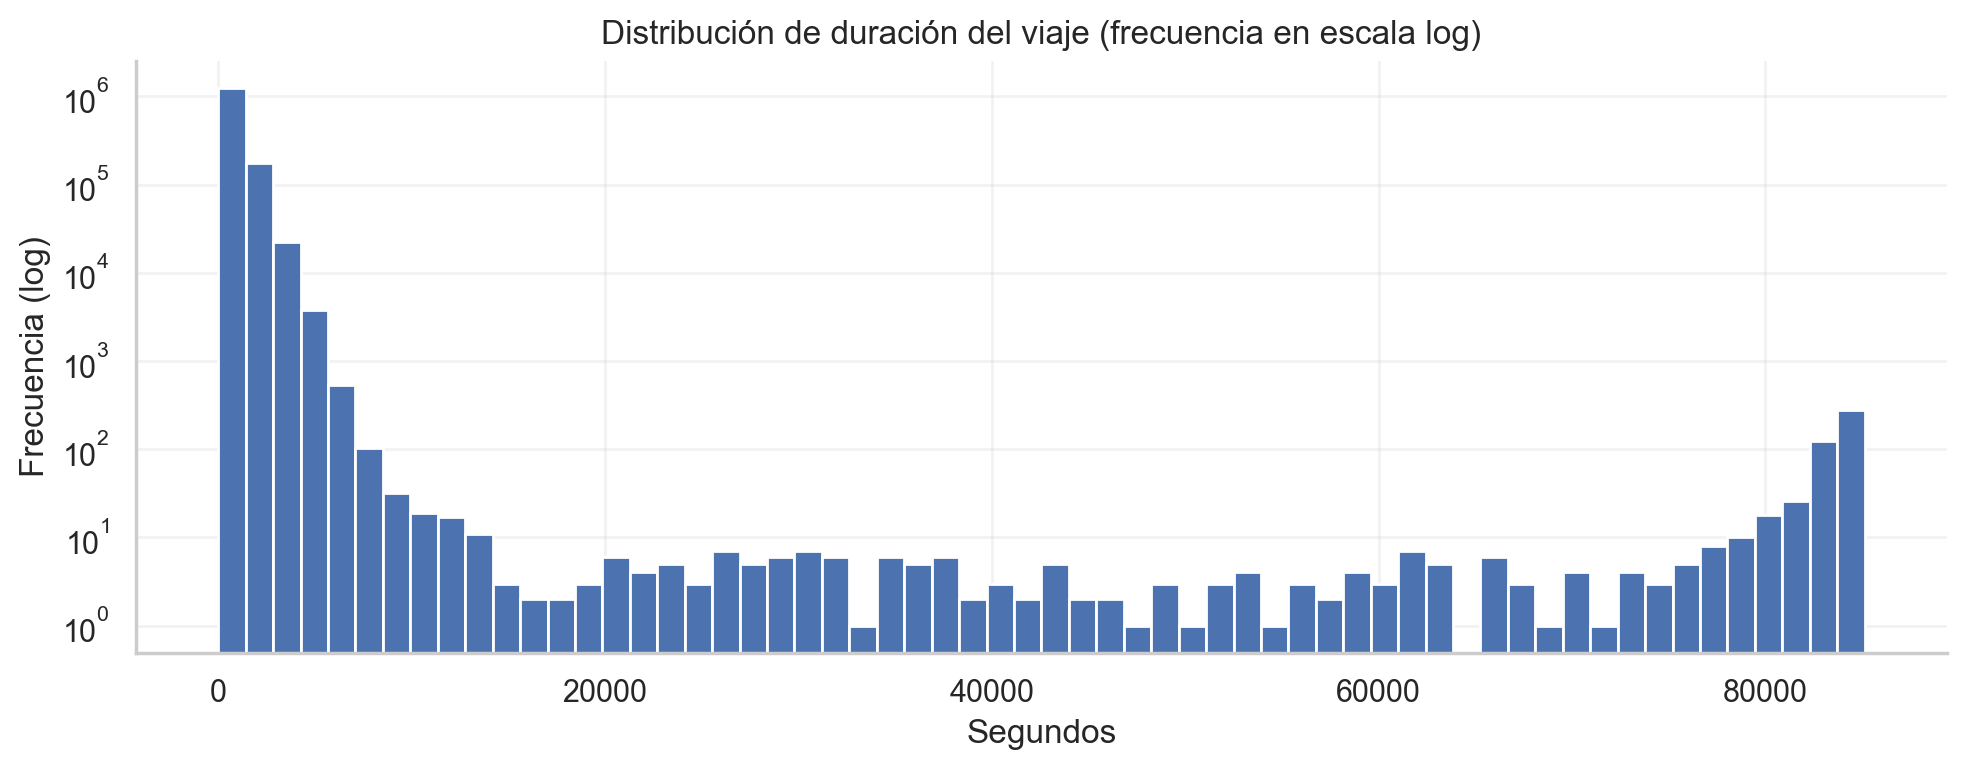

In [17]:
# ================================
# 5.1) Distribución (log) de duración o variable numérica
# ================================
fig, ax = plt.subplots(figsize=(10,4))

if "trip_seconds" in df.columns:
    x = df["trip_seconds"].dropna()
    x = x[(x > 0) & (x < x.quantile(0.999))]
    ax.hist(x, bins=60, log=True)
    ax.set_title("Distribución de duración del viaje (frecuencia en escala log)")
    ax.set_xlabel("Segundos")
    ax.set_ylabel("Frecuencia (log)")
else:
    any_num = df.select_dtypes(include="number").columns[0]
    x = df[any_num].dropna()
    ax.hist(x, bins=60, log=True)
    ax.set_title(f"Distribución de {any_num} (frecuencia en escala log)")
    ax.set_xlabel(any_num)
    ax.set_ylabel("Frecuencia (log)")

clean_axes(ax)
plt.tight_layout()

p1 = ASSETS_DIR / "hist_log_duration.png"
fig.savefig(p1, dpi=160)
p1


WindowsPath('report_assets/hexbin_pickup.png')

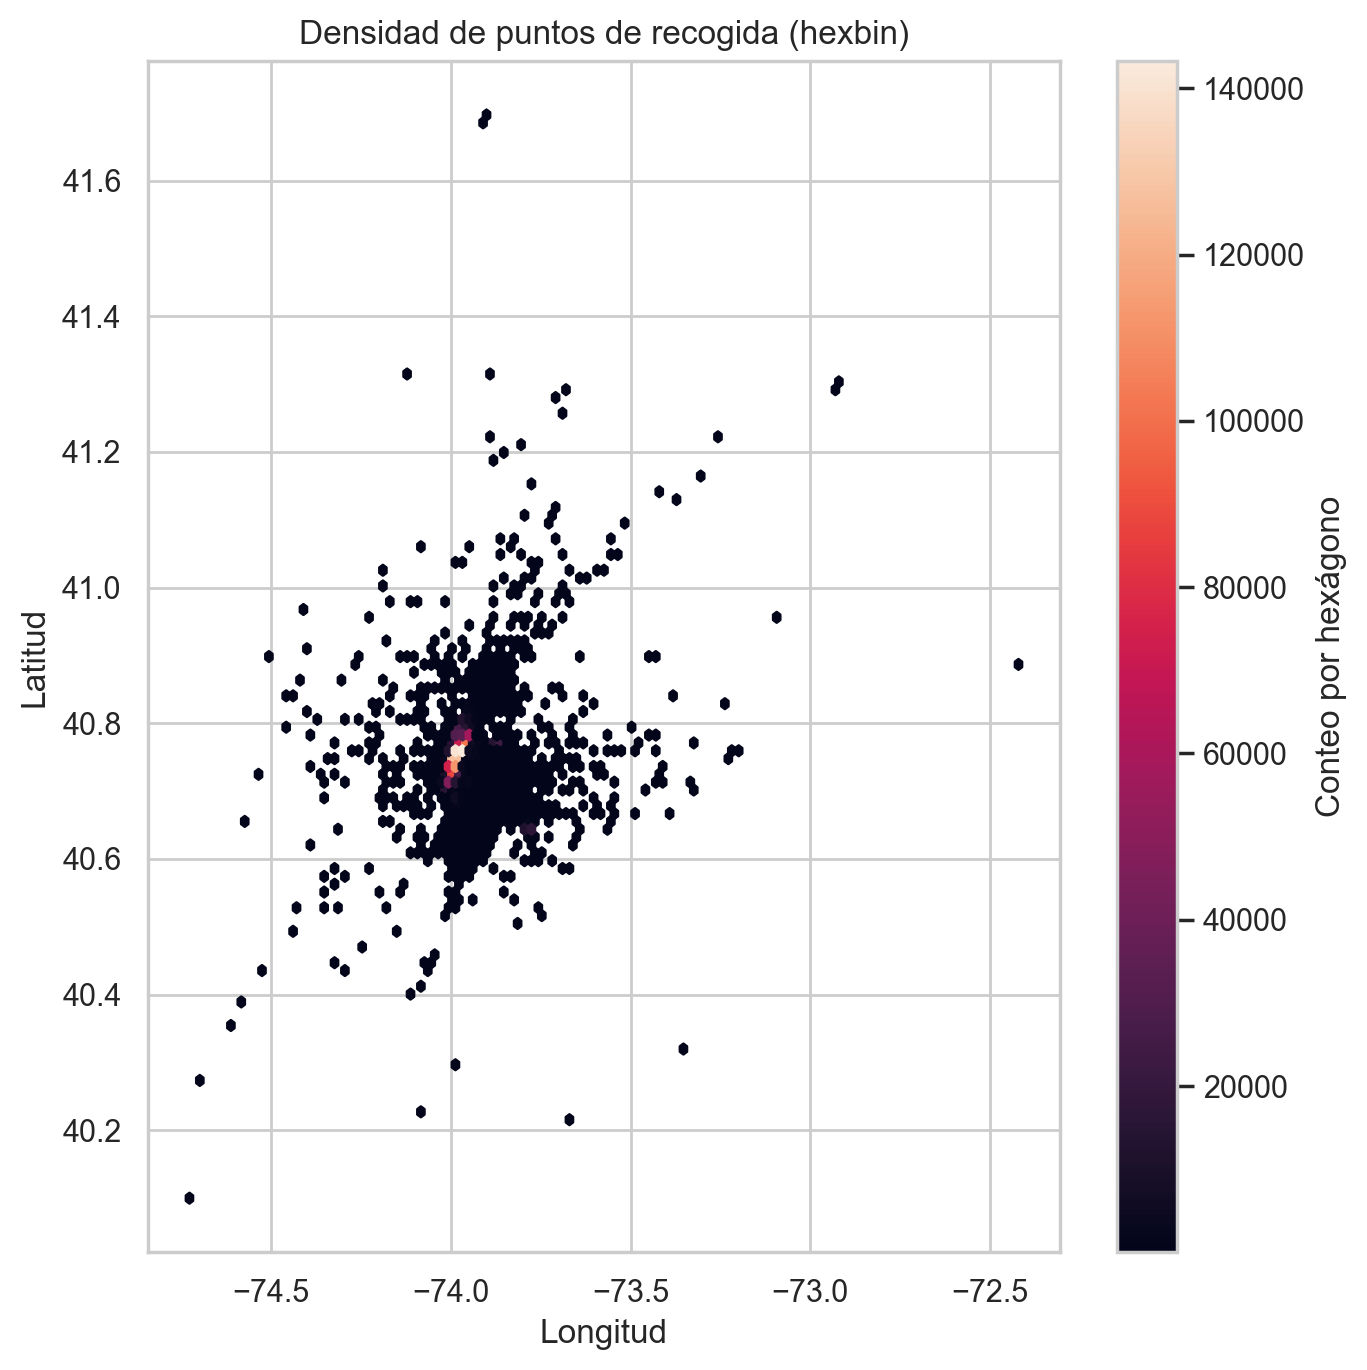

In [18]:
# ================================
# 5.2) Overplotting geoespacial: Hexbin de puntos de pickup
# ================================
fig, ax = plt.subplots(figsize=(7,7))

if have_geo:
    x = df[latlon_map["pickup_longitude"]]
    y = df[latlon_map["pickup_latitude"]]
    m = x.between(-75, -72) & y.between(40, 42)
    x, y = x[m], y[m]

    hb = ax.hexbin(x, y, gridsize=120, mincnt=1)
    ax.set_title("Densidad de puntos de recogida (hexbin)")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    fig.colorbar(hb, ax=ax, label="Conteo por hexágono")
else:
    ax.text(0.5, 0.5, "No se encontraron columnas de lat/lon.", ha="center", va="center")
    ax.set_axis_off()

plt.tight_layout()
p2 = ASSETS_DIR / "hexbin_pickup.png"
fig.savefig(p2, dpi=160)
p2


WindowsPath('report_assets/heatmap_dow_hour.png')

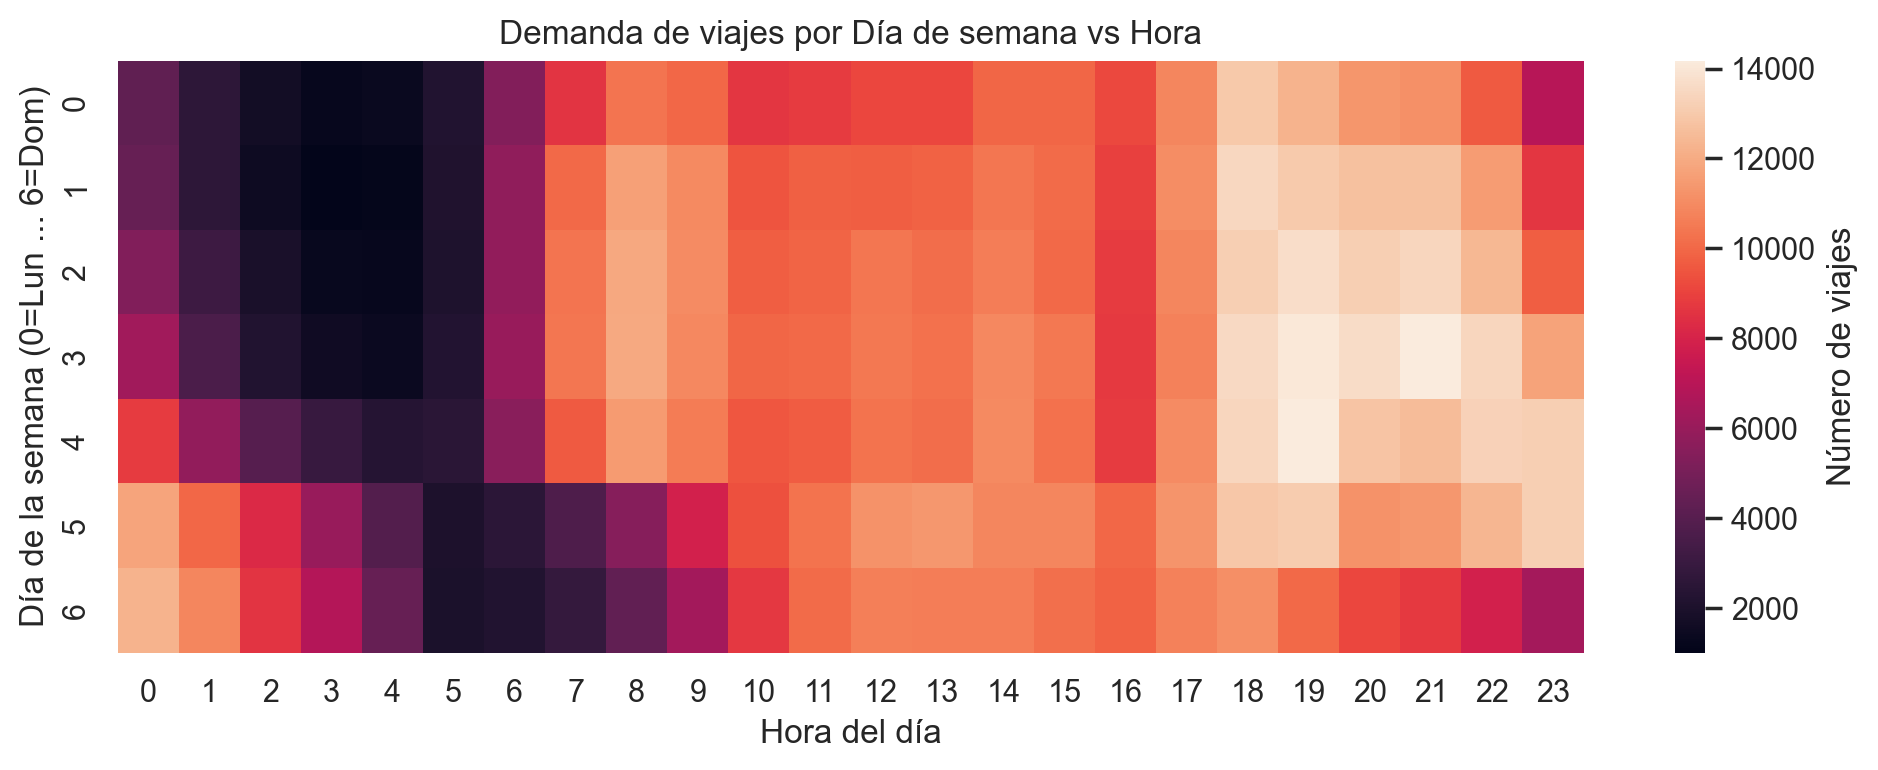

In [19]:
# ================================
# 5.3) Heatmap: demanda por hora vs día
# ================================
fig, ax = plt.subplots(figsize=(10,4))

if {"pickup_hour", "pickup_dow"}.issubset(df.columns):
    heat = (
        df.groupby(["pickup_dow", "pickup_hour"])
          .size()
          .unstack(fill_value=0)
          .astype("int32")
    )
    sns.heatmap(heat, ax=ax, cbar_kws={"label": "Número de viajes"})
    ax.set_title("Demanda de viajes por Día de semana vs Hora")
    ax.set_xlabel("Hora del día")
    ax.set_ylabel("Día de la semana (0=Lun ... 6=Dom)")
else:
    ax.text(0.5, 0.5, "No se encontraron variables temporales (pickup_hour/pickup_dow).", ha="center", va="center")
    ax.set_axis_off()

plt.tight_layout()
p3 = ASSETS_DIR / "heatmap_dow_hour.png"
fig.savefig(p3, dpi=160)
p3


## 6) Capstone: Reporte PDF automático
Generamos un PDF que:
- resume la reducción de memoria;
- incluye gráficos clave;
- queda como entregable final.


In [20]:
# ================================
# 6.1) Insights para el reporte
# ================================
insights = []
insights.append(f"Dataset: {df.shape[0]:,} filas y {df.shape[1]:,} columnas.")
insights.append(f"Memoria antes: {mem_before:,.2f} MB.")
insights.append(f"Memoria después: {mem_after:,.2f} MB.")
insights.append(f"Reducción: {reduction_pct:0.2f}%.")

if {"pickup_hour", "pickup_dow"}.issubset(df.columns):
    peak_hour = df["pickup_hour"].value_counts().idxmax()
    peak_dow = df["pickup_dow"].value_counts().idxmax()
    insights.append(f"Pico de demanda: hora {int(peak_hour)} y día {int(peak_dow)} (0=Lun ... 6=Dom).")

if "distance_km" in df.columns:
    insights.append(f"Distancia mediana: {float(df['distance_km'].median()):0.2f} km.")

if "trip_seconds" in df.columns:
    insights.append(f"Duración mediana: {float(df['trip_seconds'].median())/60:0.1f} min.")

for s in insights:
    print('•', s)


• Dataset: 1,458,644 filas y 17 columnas.
• Memoria antes: 461.84 MB.
• Memoria después: 146.06 MB.
• Reducción: 68.37%.
• Pico de demanda: hora 18 y día 4 (0=Lun ... 6=Dom).
• Distancia mediana: 2.09 km.
• Duración mediana: 11.0 min.


In [28]:
# ================================
# 6.2) PDF con FPDF
# ================================
from pathlib import Path
from fpdf.fpdf import FPDF

REPORT_PATH = Path("Reporte_Reto_Modulo1.pdf")

pdf = FPDF(orientation="P", unit="mm", format="A4")
pdf.set_auto_page_break(auto=True, margin=12)

pdf.add_page()  # <-- SIEMPRE antes de escribir

pdf.set_font("Helvetica", "B", 14)
pdf.set_x(pdf.l_margin)
pdf.multi_cell(0, 8, "Reto de Ingenieria de Datos: Optimizacion y Visualizacion")

pdf.set_font("Helvetica", "", 11)
pdf.set_x(pdf.l_margin)
pdf.multi_cell(0, 6, "Diplomado en Estrategias de Datos - USTA")
pdf.set_x(pdf.l_margin)
pdf.ln(2)
pdf.set_x(pdf.l_margin)
pdf.multi_cell(0, 6, "Estudiante: Melissa Cespedes")
pdf.set_x(pdf.l_margin)
pdf.multi_cell(0, 6, "Fecha: 2026-01-03")

# Inserta imágenes si existen (opcional)
imgs = [
    ASSETS_DIR / "hist_log_duration.png",
    ASSETS_DIR / "hexbin_pickup.png",
    ASSETS_DIR / "heatmap_dow_hour.png",
]
for img in imgs:
    if img.exists():
        pdf.ln(4)
        pdf.image(str(img), w=180)

pdf.output(str(REPORT_PATH))
print(f"PDF generado: {REPORT_PATH.resolve()}")

PDF generado: C:\Users\chroj\Reto_Modulo_Pandas_Ingrid_Cespedes\Reto_Modulo_Pandas_Ingrid_Cespedes\Reporte_Reto_Modulo1.pdf


##  Conclusiones y hallazgos
1. **Memoria:** Se logró una reducción de memoria (objetivo: ≥ 50%).  
2. **Patrones:** La demanda varía por hora y día, y la concentración espacial se aprecia mejor con `hexbin`.  
3. **Técnica:** El enfoque vectorizado (Pandas + NumPy) facilita escalar el análisis sin “Python calculadora”.
